In [1]:
library(ggplot2)
library(ComplexHeatmap)
library(ggplot2)
library(survival)
library(survminer)
library(forestplot)
library(meta)
library(epitools)

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: ggpubr

Loading required package: magrittr

Loading required package: checkmate

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Loading 'meta' package (version 6.2-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
o

In [2]:
datasets = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_with_therapy.rds")
datasets_overview = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/datasets_overview.csv",quote = "")
ref_path_OS = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_OS_total_survival_pm.rds")
ref_path_PFS = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_PFS_total_survival_pm.rds")
datasets_names = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F,row.names = 1)

In [3]:
colnames(datasets_names) = "Cohort_name"
datasets_overview = cbind(datasets_names,datasets_overview)

datasets_overview$OS = FALSE
datasets_overview$PFS = FALSE
datasets_overview$RECIST = FALSE
datasets_overview$RESPONSE = FALSE
datasets_overview$TMB = FALSE
datasets_overview$RNA = FALSE
for(i in rownames(datasets_overview)){
    if( "OS_TIME" %in% colnames(datasets[[i]]) ){datasets_overview[i,"OS"] = TRUE}
    if( "PFS_TIME" %in% colnames(datasets[[i]]) ){datasets_overview[i,"PFS"] = TRUE}
    if( "RECIST" %in% colnames(datasets[[i]]) ){datasets_overview[i,"RECIST"] = TRUE}
    if( "RESPONSE" %in% colnames(datasets[[i]]) ){datasets_overview[i,"RESPONSE"] = TRUE}
    if( "TMB" %in% colnames(datasets[[i]]) ){datasets_overview[i,"TMB"] = TRUE}
}

datasets_overview[c("dataset2","dataset6","dataset8","dataset10","dataset11","dataset12","dataset13","dataset14","dataset20"),"RNA"] = TRUE

In [4]:
# 这是旧版本dataset_overview的归纳
datasets_overview$Cancer_type2 = datasets_overview$Cancer_type
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Renal Cell Carcinoma","Renal Cell Carcinoma","Clear cell renal cell carcinoma")] = "Renal Cell Carcinoma"
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Bladder Cancer","Urothelial cancer")] = "Urothelial Cancer"
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Esophagogastric Cancer","Gastrointestinal cancer","Colorectal Cancer","Gastric cancer","Neuroendocrine neoplasms","Gastrointestinal cancer","Hepatocellular carcinoma")] = "Gastrointestinal Cancer"
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Glioblastoma","Glioma")] = "Glioblastoma"
datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
                               c("Esophagogastric Cancer","Colorectal Cancer","Pan-GI cancer","Neuroendocrine tumours","Hepatocellular carcinoma")] = "Gastrointestinal Cancer"

In [5]:
datasets_names$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_names$Cohort_name)
datasets_overview$Cohort_name = datasets_names$Cohort_name

In [6]:
ref_single = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_OS_total_survival.rds")

In [7]:
dataset_meta = read.csv("/home/ncpsb/new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F)
dataset_name = dataset_meta$V2
names(dataset_name) = dataset_meta$V1
dataset_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",dataset_name)

In [8]:
All = readRDS("/srv/shiny-server/SNVIO_V7/Refence_datasets_COX.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")

ref_cohort_cal_TMB = function(dataset,cutoff_ratio = 0.5){
  

    tmp_data = All[[dataset]]
    cutoff = quantile(na.omit(tmp_data[,"TMB"]),probs = 1-cutoff_ratio,na.rm = T)
    low = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) < cutoff]
    high = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) >= cutoff]
  
  return(list("low"=low,"high"=high))
  
}

### OS

In [9]:
cohort = vector()
low = vector()
high = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3)
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     low = c(low,length(tmp_cohort$low))
#     high = c(high,length(tmp_cohort$high))
    
    tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))
      
    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        
        low = c(low,table(tmp_data$groups)["TMB low"])
        high = c(high,table(tmp_data$groups)["TMB high"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    
    }

    
    
    
  }
}


TMB_tmp = data.frame(high,low,logtest,waldtest,HR_mean,HR_lower,HR_upper,cohort)

tmp_names = rownames(datasets_overview)
names(tmp_names) = datasets_overview$Cohort_name

TMB_tmp$cohort = rownames(TMB_tmp)
TMB_tmp$Cancer_type = datasets_overview[TMB_tmp$cohort,"Cancer_type"]
TMB_tmp$Cancer_type2 = datasets_overview[TMB_tmp$cohort,"Cancer_type2"]
TMB_tmp$gene = "TMB"

In [11]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_OS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_OS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.25) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [13]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset5","dataset7","dataset13","dataset16","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [14]:
colnames(TMB_tmp) = colnames(tmp)

In [15]:
tmp = rbind(tmp,TMB_tmp)

In [16]:
tmp$RS = -log(x = tmp$`Wald_test(OS)`,20) * log10(tmp$`HR(OS)`)

In [17]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [18]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [19]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [20]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [22]:
OS_RS_matrix = RS_matrix

### PFS

In [23]:
cohort = vector()
low = vector()
high = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3)
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("PFS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     low = c(low,length(tmp_cohort$low))
#     high = c(high,length(tmp_cohort$high))
    
    tmp_data = All[[i]][,c("PFS_TIME","PFS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        low = c(low,table(tmp_data$groups)["TMB low"])
        high = c(high,table(tmp_data$groups)["TMB high"])


        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    
    }
    
  }
}

TMB_tmp = data.frame(high,low,logtest,waldtest,HR_mean,HR_lower,HR_upper,cohort)

tmp_names = rownames(datasets_overview)
names(tmp_names) = datasets_overview$Cohort_name

TMB_tmp$cohort = rownames(TMB_tmp)
TMB_tmp$Cancer_type = datasets_overview[TMB_tmp$cohort,"Cancer_type"]
TMB_tmp$Cancer_type2 = datasets_overview[TMB_tmp$cohort,"Cancer_type2"]
TMB_tmp$gene = "TMB"

In [24]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_PFS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_PFS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.25) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [25]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset1.1","dataset1.2","dataset1.3","dataset1.4","dataset1.5","dataset1.6","dataset1.7","dataset1.8","dataset1.9",
                        "dataset1","dataset8","dataset10","dataset11","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [27]:
colnames(TMB_tmp) = colnames(tmp)
tmp = rbind(tmp,TMB_tmp)

In [28]:
tmp$RS = -log(x = tmp$`Wald_test(PFS)`,20) * log10(tmp$`HR(PFS)`)

In [29]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [30]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [31]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [32]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [34]:
PFS_RS_matrix = RS_matrix

In [35]:
share_pathway = intersect(rownames(OS_RS_matrix),rownames(PFS_RS_matrix))
OS_RS_matrix2 = OS_RS_matrix[share_pathway,]
OS_RS_matrix2$Overview = OS_RS_matrix[share_pathway,]$MultiTumor_ALL_pan_clean + PFS_RS_matrix[share_pathway,c("MultiTumor_ALL_pan_clean")]
OS_RS_matrix2 = OS_RS_matrix2[ order(OS_RS_matrix2$Overview),]

In [37]:
color = c(colorRampPalette(rev(RColorBrewer::brewer.pal(n =9,name = "Blues")))(12)[1:11],
  colorRampPalette(RColorBrewer::brewer.pal(n =9,name = "Reds"))(11)[2:11])

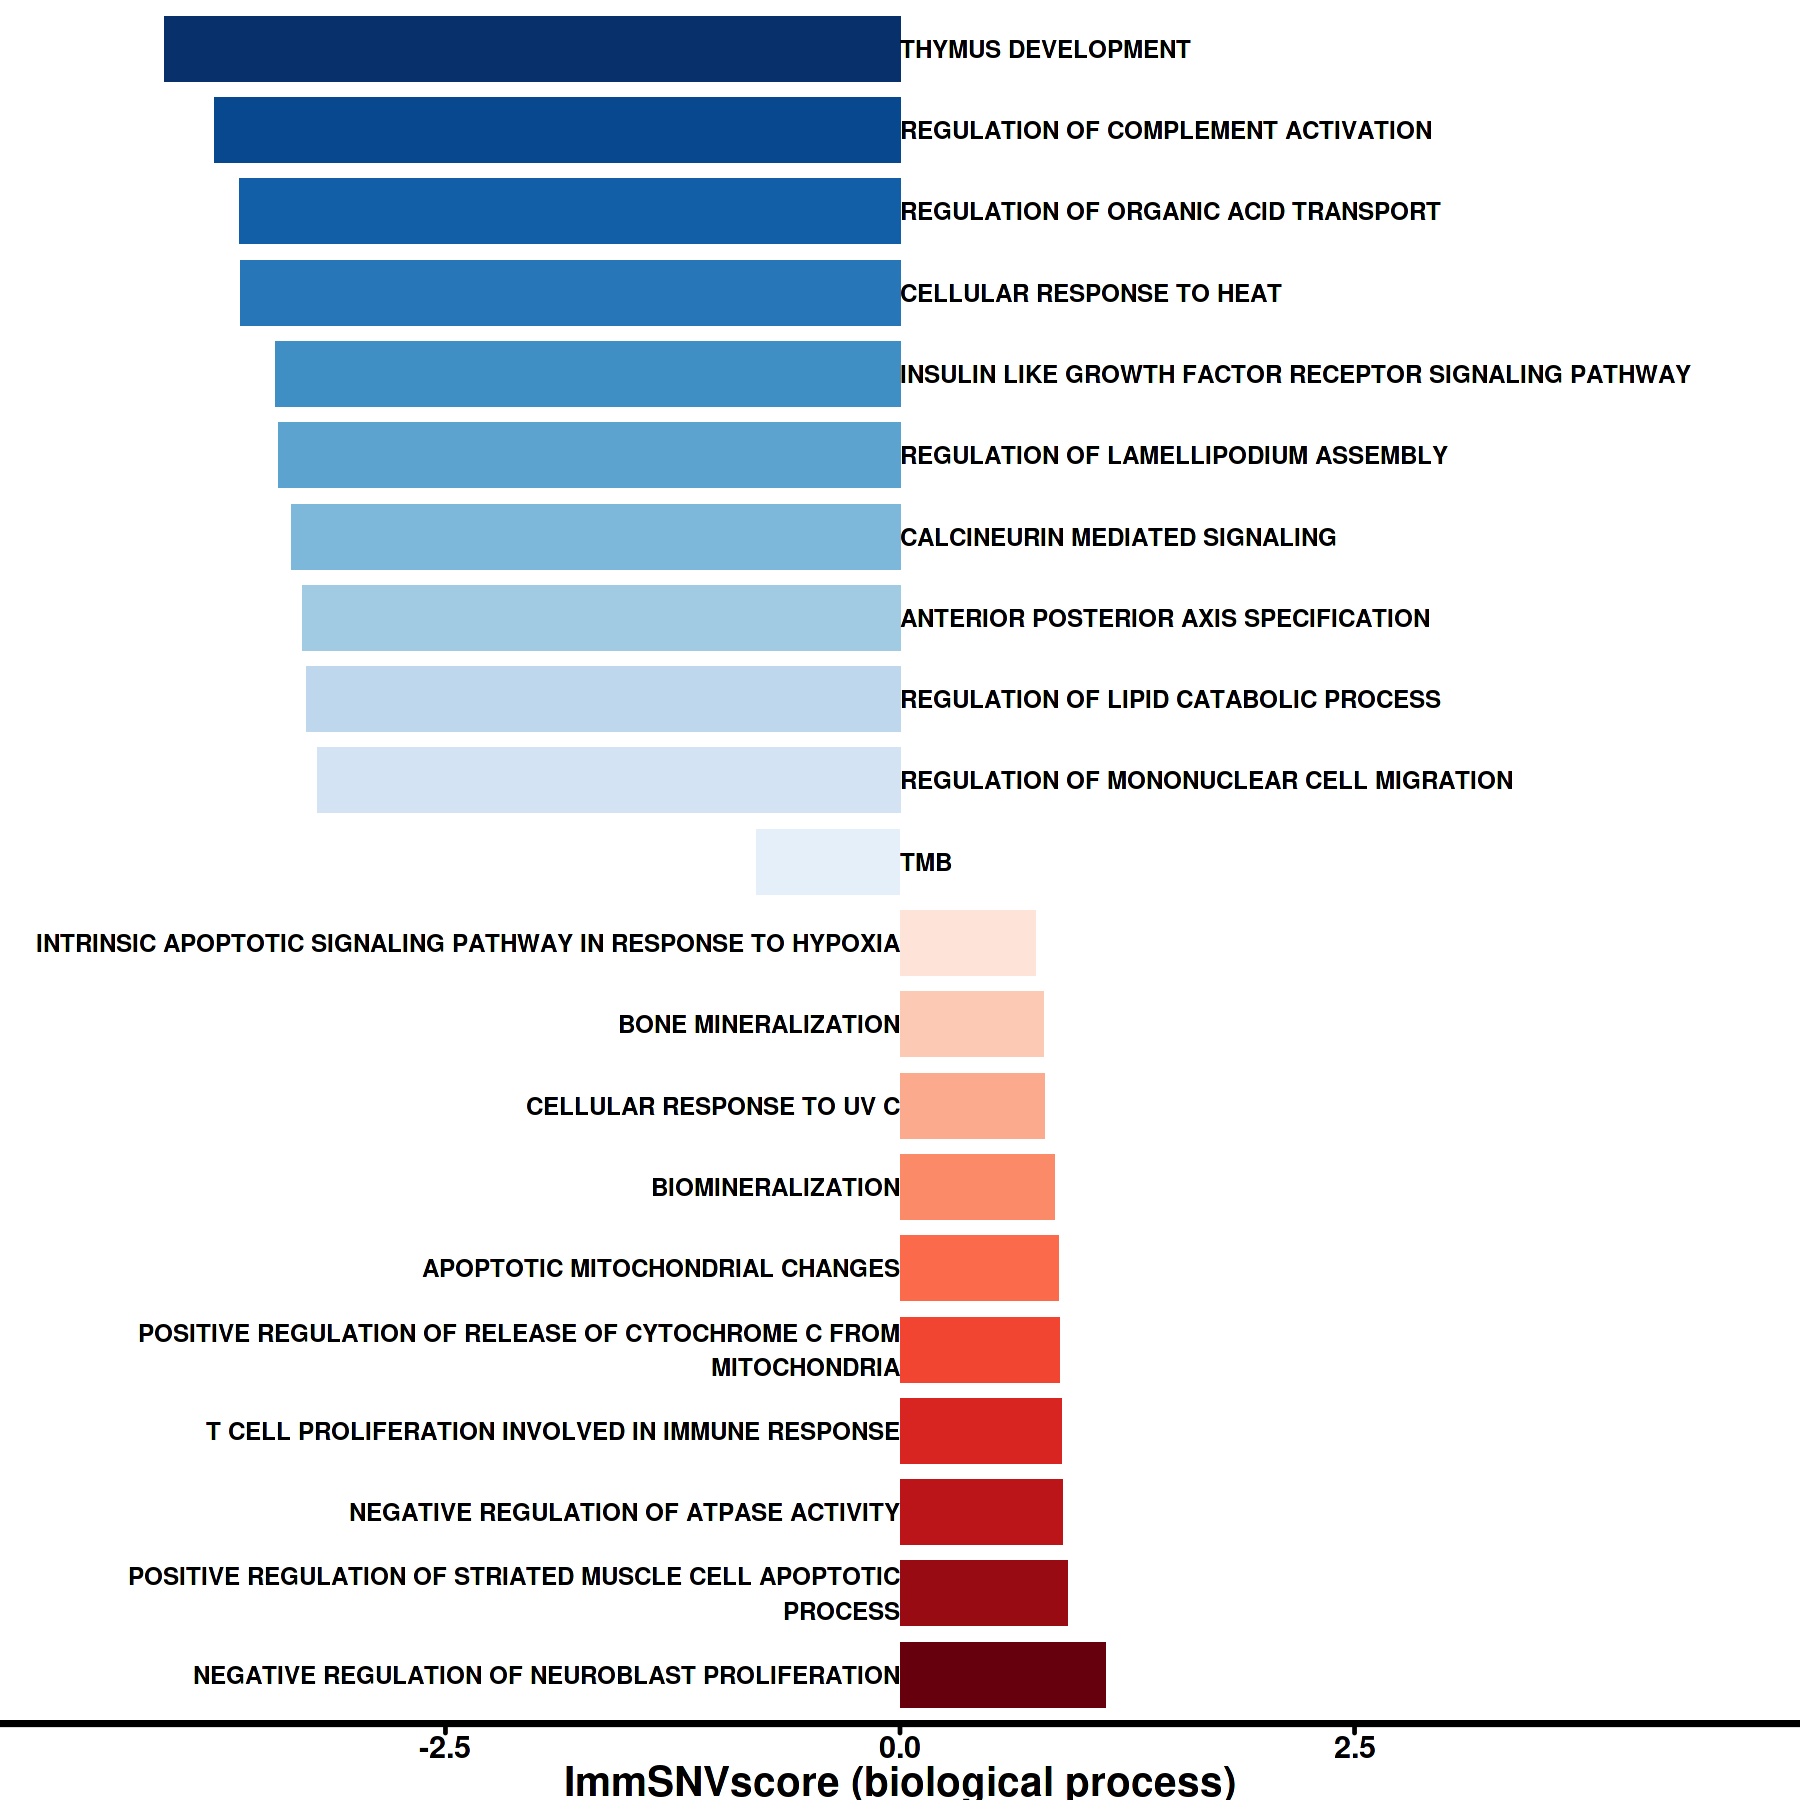

In [45]:
OS_RS_matrix3 = OS_RS_matrix2[grepl("GOBP|TMB",rownames(OS_RS_matrix2)),] 

OS_RS_matrix3 = OS_RS_matrix3[ order(OS_RS_matrix3$Overview,decreasing = T),]
OS_RS_matrix3$gene = rownames(OS_RS_matrix3)

tmp_matrix = OS_RS_matrix3[c(c(rownames(OS_RS_matrix3)[1:10],"TMB"),rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-9):nrow(OS_RS_matrix3)]),]

tmp_matrix$color = c(rep("unfavor",11),rep("favor",10))

library(stringr)
tmp_matrix$gene = str_wrap(sapply(strsplit(as.character(tmp_matrix$gene),split = "_"),function(x) if(x[1] == "TMB"){"TMB"}else{paste(x[2:length(x)],collapse = " ")}),width = 60)
tmp_matrix$gene = factor(tmp_matrix$gene,levels = tmp_matrix$gene)

tmp_matrix$hjust = NA
tmp_matrix$hjust[1:10] = 1
tmp_matrix$hjust[(11):(21)] = 0


options(repr.plot.height = 15, repr.plot.width = 15)
p = ggplot(data = tmp_matrix)+
        geom_bar(aes(x = gene,y = Overview,fill=gene),stat = "identity",width=0.8,show.legend = F)+
        coord_flip()+
    geom_text(aes(x = gene,y = 0,label = gene,hjust = hjust),fontface ="bold",size = 5)+
      scale_fill_manual(values = rev(color))+
        theme_void()+
    ylim(c(-4.5,4.5))+
#         guides(fill=guide_legend(override.aes = list(size=15)))+
        theme(axis.line.x = element_line(colour = "black",linetype = "solid",size = 1.5),
              axis.ticks.length.x = unit(2,"mm"),
              axis.ticks.x = element_line(colour = "black",linetype = "solid",size = 1 ),
              axis.text.x = element_text(angle = 0,hjust = 0.5,size=18,face = "bold"),
              axis.title.y = element_blank(),
              axis.text.y = element_blank(),
              legend.title = element_blank(),
              legend.text = element_text(size = 24,face = "bold"),
              axis.title.x = element_text(face="bold",size = 24),
              legend.position = c(0.9,0.2))+
        ylab("ImmSNVscore (biological process)")
p